In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import tensorflow as tf
import seaborn as sn
from random import shuffle
import statistics
import csv

from tensorflow.keras.layers import Input, Lambda, Concatenate, Dense, Flatten, Conv2D, Conv3D, Conv1D, AveragePooling2D, AveragePooling3D, AveragePooling1D, BatchNormalization, Dropout,MaxPooling3D, MaxPooling2D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import CSVLogger

import numpy as np
from glob import glob
from tensorflow.keras.layers import MaxPooling2D

from matplotlib import pyplot

# ESN implementation

In [3]:
class ESN:
    def __init__(self, N_inputs, N_reservoir = 50, spectral_radius = 1, sparsity = 0, noise = 0.001, random_state = None):
        
        self.N_inputs = N_inputs
        self.N_reservoir = N_reservoir
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.random_state = random_state

        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand
        self.initweights()
        
        
    def initweights(self):
        W = self.random_state_.rand(self.N_reservoir, self.N_reservoir) - 0.5
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        self.W = W * (self.spectral_radius / radius)
        self.W_in = self.random_state_.rand(
                    self.N_reservoir, self.N_inputs) * 2 - 1
       
    def _update(self, state, input_pattern):
        preactivation = (np.dot(self.W, state)+ np.dot(self.W_in, input_pattern))
        return (np.tanh(preactivation)+ self.noise * (self.random_state_.rand(self.N_reservoir) - 0.5))
        
    def fit_internal_state(self, inputs, inspect=False):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))

        states = np.zeros((inputs.shape[0], self.N_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs[n, :])
            
        extended_states = np.hstack((states, inputs))

        if inspect:
            from matplotlib import pyplot as plt
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',interpolation='nearest')
            plt.colorbar()
            print(states.shape)
        
        return states

## Open dataset file

In [6]:
#List file of a specific directory. Save the red data to a vec. Naming the vector with ID file name.

from os import listdir
from os.path import isfile, join, isdir
import pandas as pd

##### Change the path with your correct path
#mypath_Windows= "C:/Users/Utente/Desktop/Time_Series_Classification/SisFall_dataset/"
#mypath_MacOS= "/Users/username/Desktop/Time_Series_Classification/SisFall_dataset/"
mypath_Ubuntu = "/home/username/Scrivania/Time_Series_Classification/SisFall_dataset/"
onlydirectory = [f for f in listdir(mypath_Ubuntu) if isdir(join(mypath_Ubuntu, f))]

vec_a_X = []
vec_a_Y = []
vec_a_Z = []

i = 0 

for directory in onlydirectory:
    sub_dir = mypath_Ubuntu + directory  

    #Show all file in the sub_directory
    onlyfile = [f for f in listdir(sub_dir) if isfile(join(sub_dir, f))]
    
    for txt_file in onlyfile:
        
        #Recognize if is a .txt file
        if txt_file.endswith('.txt') and txt_file[0] != ".":
            file_name = sub_dir + "/" + txt_file
            #Open file and read Data
            data = pd.read_csv(file_name, sep=',', header=None)
            
            vec_a_name = txt_file.replace(".txt","")
            
            vec_a_X.append(data[0].rename(vec_a_name))
            vec_a_X[i]
            vec_a_Y.append(data[1].rename(vec_a_name))
            vec_a_Y[i]
            vec_a_Z.append(data[2].rename(vec_a_name))
            vec_a_Z[i]

            i = i + 1
            

## Shuffle dataset

In [7]:
c = list(zip(vec_a_X, vec_a_Y, vec_a_Z))

random.seed(19)
random.shuffle(c)

vec_a_X,vec_a_Y,vec_a_Z = zip(*c)

## Time Series Standardization

In [8]:
vec_a_X_standardize = []
vec_a_Y_standardize = []
vec_a_Z_standardize = []

for j in range(len(vec_a_X)):
      
    mean_X = np.mean(vec_a_X[j])
    std_dev_X = np.std(vec_a_X[j])
    
    mean_Y = np.mean(vec_a_Y[j])
    std_dev_Y = np.std(vec_a_Y[j])
        
    mean_Z = np.mean(vec_a_Z[j])
    std_dev_Z = np.std(vec_a_Z[j])
    
    vec_a_X_standardize.append((vec_a_X[j]-mean_X)/std_dev_X)
    vec_a_Y_standardize.append((vec_a_Y[j]-mean_Y)/std_dev_Y)
    vec_a_Z_standardize.append((vec_a_Z[j]-mean_Z)/std_dev_Z)

## Generate output classes

In [9]:
vec_output_Class = []
dim_temp_series = 10000

for i in range(len(vec_a_X_standardize)):
    
    if len(vec_a_X_standardize[i]) <= dim_temp_series:
        
        if vec_a_X_standardize[i].name[0] == "D":
            array = np.array([0,1])
            vec_output_Class.append(array)

        elif vec_a_X[i].name[0] == "F":
            array = np.array([1,0])
            vec_output_Class.append(array)

# ESN layer

## Generate internal state - 3D input

In [13]:
%matplotlib notebook

N_inputs = 3
N_reservoir = 15
vec_internal_states_XYZ =[]
dim_temp_series = 10000
vec_output_Class = []


for i in range(4000):    
    input_ESN_x = vec_a_X_standardize[i].values
    input_ESN_y = vec_a_Y_standardize[i].values
    input_ESN_z = vec_a_Z_standardize[i].values
    
    if len(input_ESN_x) <= dim_temp_series:
        if len(input_ESN_x) != dim_temp_series:
            if (len(input_ESN_x)%2) != 0:
                dim_adding = int((dim_temp_series-len(input_ESN_x))/2)

                left_X = np.full(dim_adding+1, vec_a_X_standardize[i].values[0])
                right_X = np.full(dim_adding, vec_a_X_standardize[i].values[len(vec_a_X_standardize[i])-2])
                left_Y = np.full(dim_adding+1, vec_a_Y_standardize[i].values[0])
                right_Y = np.full(dim_adding, vec_a_Y_standardize[i].values[len(vec_a_Y_standardize[i])-2])
                left_Z = np.full(dim_adding+1, vec_a_Z_standardize[i].values[0])
                right_Z = np.full(dim_adding, vec_a_Z_standardize[i].values[len(vec_a_Z_standardize[i])-2])

                input_ESN_x  = np.insert(input_ESN_x, len(input_ESN_x)-1, right_X) #at the end
                input_ESN_x  = np.insert(input_ESN_x, 0, left_X)                                         
                input_ESN_y  = np.insert(input_ESN_y, len(input_ESN_y)-1, right_Y) #at the end
                input_ESN_y  = np.insert(input_ESN_y, 0, left_Y)                                        
                input_ESN_z  = np.insert(input_ESN_z, len(input_ESN_z)-1, right_Z) #at the end
                input_ESN_z  = np.insert(input_ESN_z, 0, left_Z)
                
                if vec_a_X_standardize[i].name[0] == "D":
        
                    array = np.array([0,1])
                    vec_output_Class.append(array)

                elif vec_a_X[i].name[0] == "F":
        
                    array = np.array([1,0])
                    vec_output_Class.append(array)
            else:
                dim_adding = int((dim_temp_series-len(input_ESN_x))/2)                
                        
                left_X = np.full(dim_adding, vec_a_X_standardize[i].values[0])
                right_X = np.full(dim_adding, vec_a_X_standardize[i].values[len(vec_a_X_standardize[i])-1])
                left_Y = np.full(dim_adding, vec_a_Y_standardize[i].values[0])
                right_Y = np.full(dim_adding, vec_a_Y_standardize[i].values[len(vec_a_Y_standardize[i])-1])
                left_Z = np.full(dim_adding, vec_a_Z_standardize[i].values[0])
                right_Z = np.full(dim_adding, vec_a_Z_standardize[i].values[len(vec_a_Z_standardize[i])-1])
            
                input_ESN_x  = np.insert(input_ESN_x, len(input_ESN_x)-1, right_X)
                input_ESN_x  = np.insert(input_ESN_x, 0, left_X)                            
                input_ESN_y  = np.insert(input_ESN_y, len(input_ESN_y)-1, right_Y)
                input_ESN_y  = np.insert(input_ESN_y, 0, left_Y)                             
                input_ESN_z  = np.insert(input_ESN_z, len(input_ESN_z)-1, right_Z)
                input_ESN_z  = np.insert(input_ESN_z, 0, left_Z)
                
                if vec_a_X_standardize[i].name[0] == "D":
        
                    array = np.array([0,1])
                    vec_output_Class.append(array)

                elif vec_a_X[i].name[0] == "F":
        
                    array = np.array([1,0])
                    vec_output_Class.append(array)
                             
            if len(input_Conv_ESN_x) != dim_temp_series: 
                print("!!! Different DIM !!!")
    
        esn = ESN(N_inputs = N_inputs,
                    N_reservoir = N_reservoir,
                    noise=0.1,
                    spectral_radius = 1.5,
                    random_state=40)

        input_ESN = np.array([input_ESN_x,input_ESN_y,input_ESN_z]).reshape(dim_temp_series,N_inputs)
        internal_states_XYZ = esn.fit_internal_state(input_ESN,inspect=False)        
        vec_internal_states_XYZ.append(internal_states_XYZ)

# Convolutional/Flattening/Fully Connected layer

#### To implement this part we use the open source TensorFlow/Keras library

In [14]:
trainlen = 900
testlen = 300
shift_trainlen = 0
shift_testlen = 0

X_train = np.array(vec_internal_states_XYZ[0+shift_trainlen:trainlen+shift_trainlen])
Y_train = np.array(vec_output_Class[0+shift_trainlen:trainlen+shift_trainlen])
X_train = tf.stack(X_train)
Y_train = tf.stack(Y_train)
X_train = tf.expand_dims(X_train, axis=-1)

X_test = np.array(vec_internal_states_XYZ[trainlen+shift_testlen+shift_trainlen:trainlen+testlen+shift_trainlen+shift_testlen])
Y_test = np.array(vec_output_Class[trainlen+shift_testlen+shift_trainlen:trainlen+testlen+shift_testlen+shift_trainlen])
X_test = tf.expand_dims(X_test, axis=-1)


model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(dim_temp_series,N_reservoir,1), kernel_regularizer=regularizers.l2(l=0.01)))
model.add(AveragePooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu", kernel_regularizer=regularizers.l2(l=0.01)))
model.add(AveragePooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(80,activation="relu"))
model.add(Dense(20,activation="relu"))
model.add(Dense(2,activation="softmax"))

opt = SGD(lr=0.01)
opt_adam = 'adam'

binary_crossentropy = 'binary_crossentropy'

model.compile(loss=binary_crossentropy,optimizer=opt_adam,metrics=['accuracy'])
print(model.summary())

2022-09-13 12:47:12.852228: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-13 12:47:12.857969: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-13 12:47:12.906924: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10000, 15, 16)     80        
_________________________________________________________________
average_pooling2d (AveragePo (None, 5000, 7, 16)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5000, 7, 16)       64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5000, 7, 32)       2080      
_________________________________________________________________
average_pooling2d_1 (Average (None, 2500, 3, 32)       0         
_________________________________________________________________
flatten (Flatten)            (None, 240000)            0         
_________________________________________________________________
dense (Dense)                (None, 80)                1

In [15]:
# Let's fit the model using csv_logger which allows to stream epoch results to a CSV file.

csv_logger = CSVLogger("model_history_3D(single)_xres=15.csv", append=True)
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, callbacks=[csv_logger])

2022-09-13 12:47:29.212313: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-13 12:47:29.236452: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


Epoch 1/30
29/29 [==============================] - 22s 731ms/step - loss: 6.4146 - accuracy: 0.7618 - val_loss: 0.3984 - val_accuracy: 0.9633
Epoch 2/30
29/29 [==============================] - 20s 703ms/step - loss: 0.3844 - accuracy: 0.9832 - val_loss: 0.3145 - val_accuracy: 0.9900
Epoch 3/30
29/29 [==============================] - 21s 723ms/step - loss: 0.2949 - accuracy: 0.9916 - val_loss: 0.2969 - val_accuracy: 0.9933
Epoch 4/30
29/29 [==============================] - 21s 729ms/step - loss: 0.2725 - accuracy: 0.9925 - val_loss: 0.2833 - val_accuracy: 0.9933
Epoch 5/30
29/29 [==============================] - 22s 746ms/step - loss: 0.2735 - accuracy: 0.9927 - val_loss: 0.2615 - val_accuracy: 0.9933
Epoch 6/30
29/29 [==============================] - 22s 745ms/step - loss: 0.2035 - accuracy: 0.9996 - val_loss: 0.2551 - val_accuracy: 0.9967
Epoch 7/30
29/29 [==============================] - 22s 752ms/step - loss: 0.2157 - accuracy: 0.9974 - val_loss: 0.2213 - val_accuracy: 1.0000

<IPython.core.display.Javascript object>


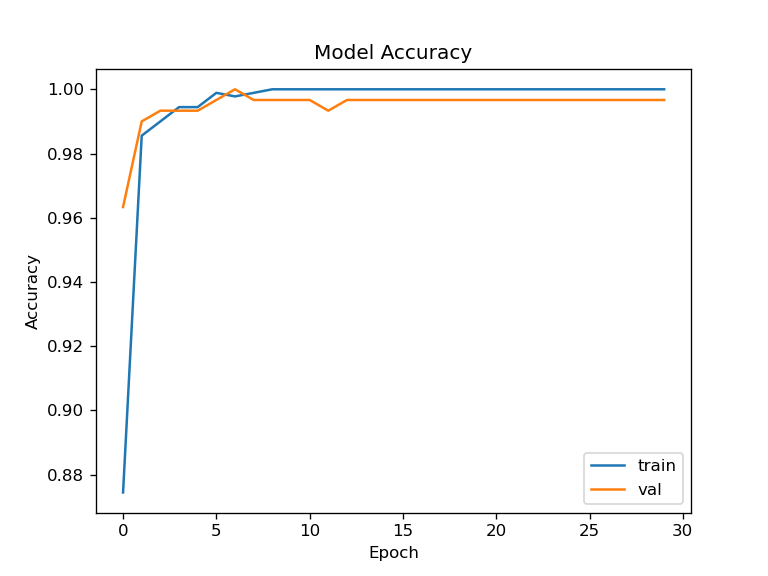

In [16]:
%matplotlib notebook
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

<IPython.core.display.Javascript object>


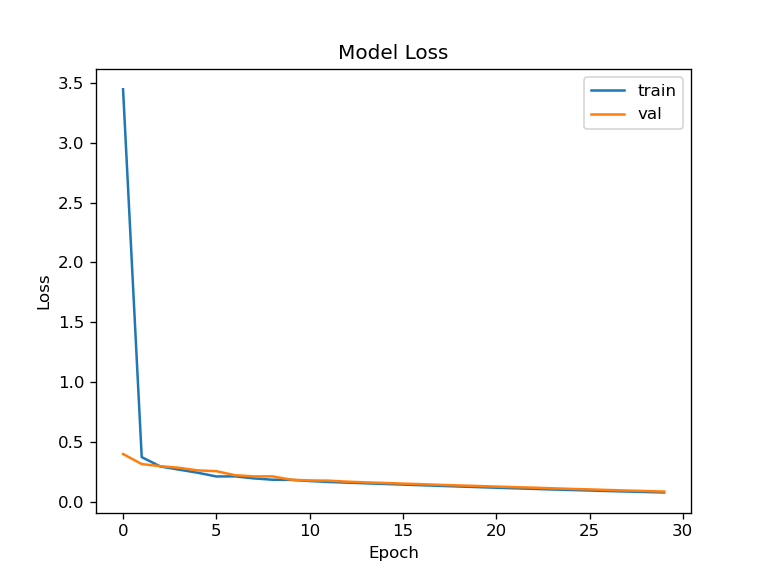

In [17]:
%matplotlib notebook
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Save & Load Keras model

In [ ]:
model.save('path/to/location')

In [ ]:
from tensorflow import keras
model = keras.models.load_model('path/to/location')


# Model prediction

In [18]:
start_len = 1200
stop_len = 2700
range_len = stop_len - start_len

X_test = np.array(vec_internal_states_XYZ[start_len:stop_len])
X_test = tf.expand_dims(X_test, axis=-1)

prediction_ = model.predict(X_test)
test_preds = np.where(prediction_ > 0.5, 1, 0)

## Plot confusion matrix 

<IPython.core.display.Javascript object>


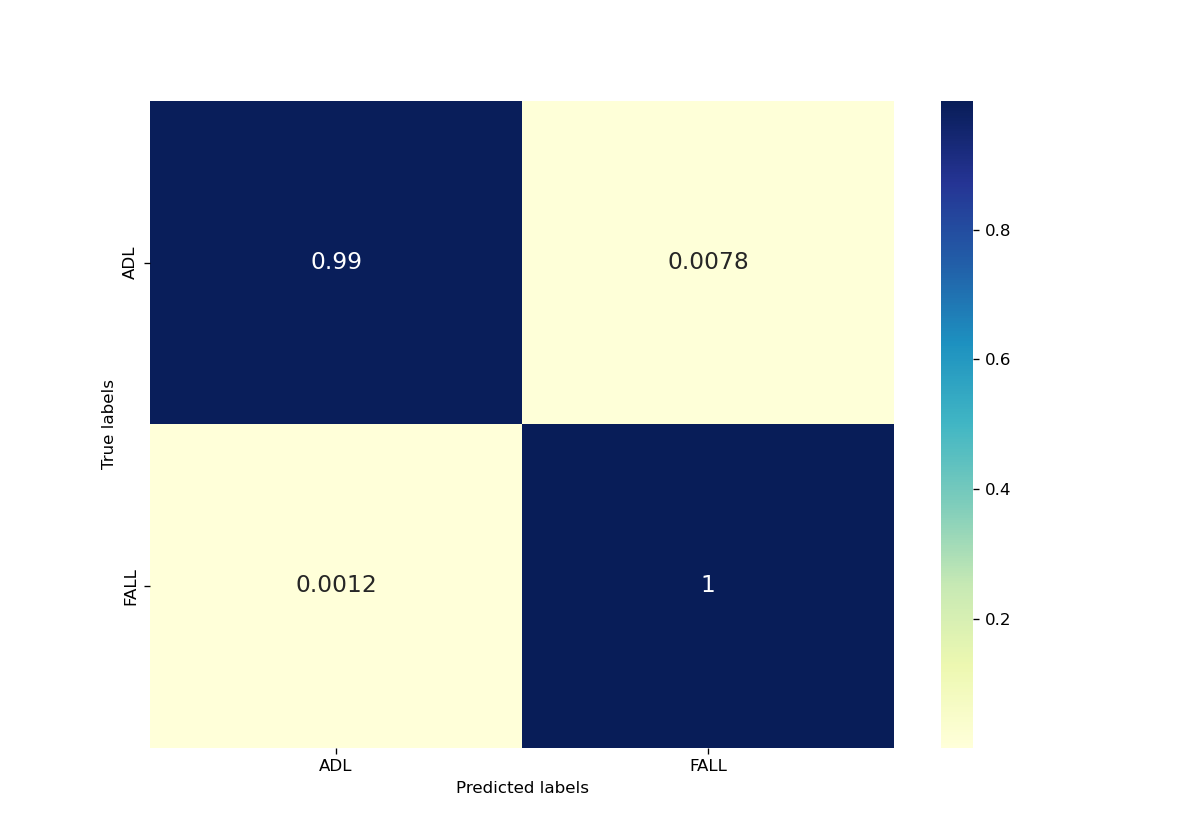

Sensitivity is :
0.9988385598141696
Specificity is :
0.9921752738654147
Accuracy is:
0.996
F1-score is:
0.996523754345307


In [19]:
%matplotlib notebook
count_correct_FIRST = 0 #TP
count_correct_SECOND = 0 #TN
count_errate_FIRST = 0 #FN
count_errate_SECOND = 0 #FP

count_FIRST = 0
count_SECOND = 0

for k in range(1500):
    if vec_output_Class[k+start_len][0] == 0:
        count_FIRST = count_FIRST + 1
        if vec_output_Class[k+start_len][0] == test_preds[k][0]:
            count_correct_FIRST = count_correct_FIRST + 1
        else:
            count_errate_FIRST = count_errate_FIRST + 1
    if vec_output_Class[k+start_len][0] == 1:
        count_SECOND = count_SECOND + 1
        if vec_output_Class[k+start_len][0] == test_preds[k][0]:
            count_correct_SECOND = count_correct_SECOND + 1
        else:
            count_errate_SECOND = count_errate_SECOND + 1

array = [[count_correct_SECOND/count_SECOND,count_errate_SECOND/count_SECOND],[count_errate_FIRST/count_FIRST,count_correct_FIRST/count_FIRST]]          
df_cm = pd.DataFrame(array, index = ["ADL","FALL"],
                    columns = ["ADL","FALL"])
plt.figure(figsize = (10,7))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax = sn.heatmap(df_cm, annot=True, cmap="YlGnBu", annot_kws={'fontsize':14})
ax.set(xlabel='Predicted labels', ylabel='True labels')
plt.show()

TP = count_correct_FIRST
TN = count_correct_SECOND
FN = count_errate_FIRST
FP = count_errate_SECOND

sensitivity = TP/(TP+FN)
specificity = TN/(TN+FP)
accuracy = (TP+TN)/(TP+TN+FP+FN)
f1_score = (2*TP)/(2*TP+FP+FN)

print("Sensitivity is :")
print(sensitivity)
print("Specificity is :")
print(specificity)
print("Accuracy is:")
print(accuracy)
print("F1-score is:")
print(f1_score)